In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import json

from copy import deepcopy
import torch.nn.functional

from torch import optim
from torch.utils.data import DataLoader

from data.datasets.random_dataset import RandomDataset
from data.datasets.golden_panels import GoldenPanelsDataset

from networks.plain_ssupervae import PlainSSuperVAE
from networks.ssupervae_contextual_attentional import SSuperVAEContextualAttentional
from training.ssupervae_contextual_attn_trainer import SSuperVAEContextualAttentionalTrainer
from training.vae_trainer import VAETrainer
from utils.config_utils import read_config, Config
from utils.plot_utils import *
from utils.logging_utils import *
from utils import pytorch_util as ptu

from configs.base_config import *
from functional.losses.elbo import elbo

from utils.image_utils import *

In [3]:
ptu.set_gpu_mode(True)
config = read_config(Config.PLAIN_SSUPERVAE)
golden_age_config = read_config(Config.GOLDEN_AGE)

panel_dim = golden_age_config.panel_dim[0]

cont_epoch = -1
cont_model = None  # "playground/ssupervae/weights/model-18.pth"
limit_size = 32

# data = RandomDataset((3, 3, 360, 360), (3, config.image_dim, config.image_dim))
data = GoldenPanelsDataset(golden_age_config.panel_path,
                           golden_age_config.sequence_path,
                           golden_age_config.panel_dim,
                           config.image_dim,
                           augment=False,
                           mask_val=golden_age_config.mask_val,
                           mask_all=golden_age_config.mask_all,
                           return_mask=golden_age_config.return_mask,
                           train_test_ratio=golden_age_config.train_test_ratio,
                           train_mode=True,
                           limit_size=limit_size)
data_loader = DataLoader(data, batch_size=config.batch_size, shuffle=True, num_workers=4)
# creating model and training details
net = SSuperVAEContextualAttentional(config.backbone,
                                     panel_img_size=panel_dim,
                                     latent_dim=config.latent_dim,
                                     embed_dim=config.embed_dim,
                                     seq_size=config.seq_size,
                                     decoder_channels=config.decoder_channels,
                                     gen_img_size=config.image_dim).to(ptu.device)

dataiter = iter(data_loader)

Loaded pretrained weights for efficientnet-b5


In [4]:
x, y, mask, mask_coordinates = next(dataiter)

x = x.to(ptu.device)
y = y.to(ptu.device)
mask = mask.to(ptu.device)

z, _, mu_z, mu_x, logstd_z = net(x)

# Preparing for Fine Generator
B, S, C, W, H = x.shape
mask = mask.view(B, 1, W, H)
x_stage_0 = ptu.zeros(B, C, H, W)
x_stage_1 = ptu.zeros_like(x_stage_0)
for i in range(len(x)):
    last_panel = x[i, 2, :, :, :]
    output_merged_last_panel = deepcopy(last_panel)

    last_panel_face = y[i, :, :, :]
    last_panel_output_face = mu_x[0, :, :, :]

    mask_coordinates_n = ptu.get_numpy(mask_coordinates[i])

    original_w = abs(mask_coordinates_n[0] - mask_coordinates_n[1])
    original_h = abs(mask_coordinates_n[2] - mask_coordinates_n[3])

    # inserting original face to last panel
    modified = last_panel_face.view(1, *last_panel_face.size())
    interpolated_last_panel_face_batch = torch.nn.functional.interpolate(modified,
                                                                         size=(original_w, original_h))
    interpolated_last_panel_face = interpolated_last_panel_face_batch[0]
    last_panel[:, mask_coordinates_n[0]: mask_coordinates_n[1] ,
    mask_coordinates_n[2]: mask_coordinates_n[3]] = interpolated_last_panel_face
    x_stage_0[i, :, :, :] = last_panel

    # inserting output face to last panel
    modified = last_panel_output_face.view(1, *last_panel_output_face.size())
    interpolated_last_panel_face_batch = torch.nn.functional.interpolate(modified,
                                                                         size=(original_w, original_h))
    interpolated_last_panel_face = interpolated_last_panel_face_batch[0]
    output_merged_last_panel[:, mask_coordinates_n[0]: mask_coordinates_n[1],
    mask_coordinates_n[2]: mask_coordinates_n[3]] = interpolated_last_panel_face
    x_stage_1[i, :, :, :] = output_merged_last_panel

x_stage_2, offset_flow = net.fine_generator(x_stage_0, x_stage_1, mask)



/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


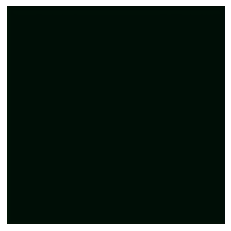

In [11]:
tst_img = x_stage_2[1]
# TODO: CHECK FACE NOT FITTING BUG
imshow(tst_img)

In [15]:
x_stage_2_masked = x_stage_2 * mask + x_stage_0 * (1. - mask)

tensor([[[[-1.2907, -0.7966,  1.0001,  ...,  0.8030,  0.9482, -1.7374],
          [-1.3678, -0.7600,  0.9608,  ...,  0.9793, -0.4372,  0.1980],
          [ 1.2685,  0.6367,  0.4149,  ...,  0.9553,  0.6226,  0.6955],
          ...,
          [ 2.1047,  1.8995,  1.8104,  ..., -0.0287,  0.0134, -0.0423],
          [ 2.0831,  1.9858,  2.1226,  ...,  1.8973,  2.0937,  2.0707],
          [ 2.0822,  2.1484,  2.1399,  ...,  2.2155,  2.2489,  2.2361]],

         [[-1.1601, -0.6555,  1.1950,  ...,  0.9328,  1.0813, -1.6642],
          [-0.9900, -0.3730,  1.3906,  ...,  1.1831, -0.2650,  0.3845],
          [ 1.7260,  1.0801,  0.8533,  ...,  1.2693,  0.9292,  1.0037],
          ...,
          [-0.3163, -0.1800, -0.3345,  ...,  0.8272,  0.8703,  0.8133],
          [ 2.1693,  1.9727,  1.9218,  ...,  2.0617,  2.2549,  2.2390],
          [ 2.0242,  1.8377,  1.8416,  ...,  2.0357,  2.1270,  2.0568]],

         [[-0.9063, -0.4040,  1.4383,  ...,  1.1161,  1.2639, -1.4525],
          [-0.8935, -0.2792,  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


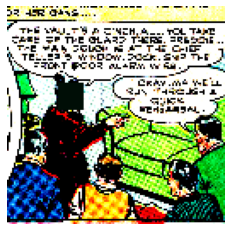

In [13]:
tst_img_masked = x_stage_2_masked[1]
# TODO: CHECK FACE NOT FITTING BUG
imshow(tst_img_masked)

In [10]:
ptu.get_numpy(tst_img).max()

0.08087072

In [77]:
x = x.to(ptu.device)
y = y.to(ptu.device)
mask = mask.to(ptu.device)

In [78]:
mask_coordinates

tensor([[ 43,  58,  30,  45],
        [  4,  24,  81, 100],
        [ 34, 111,  19,  96],
        [ 31,  81,  26,  76],
        [ 45,  63,  97, 116],
        [ 45,  61,  30,  45],
        [ 37,  89,   0,  51],
        [ 57,  92,  47,  82]])

In [79]:
last_panel = x[0, 2, :, :, :]
last_panel_face = y[0, :, :, :]
print(last_panel.size())

torch.Size([3, 128, 128])


In [80]:

z, _, mu_z, mu_x, logstd_z = net(x)

In [81]:
last_panel_face = mu_x[0, :, :, :]
# self.fine_generator(x, x_stage1, mask)
#net.fine_generator()

In [82]:
# TODO: construct x_stage_1
mask_coordinates_n = ptu.get_numpy(mask_coordinates[1])

In [83]:
mask_coordinates_n

array([  4,  24,  81, 100])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


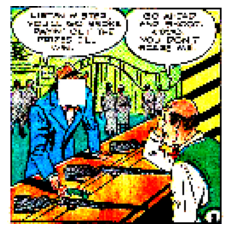

In [84]:
imshow(last_panel)

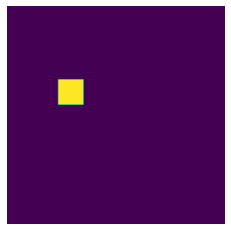

In [85]:
imshow(mask[0:1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


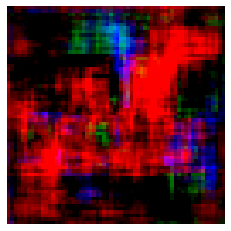

In [86]:
imshow(last_panel_face)

In [87]:
last_panel_face.size()

torch.Size([3, 64, 64])

In [88]:
original_w = abs(mask_coordinates_n[0] - mask_coordinates_n[1])
original_h = abs(mask_coordinates_n[2] - mask_coordinates_n[3])

In [89]:
modified = last_panel_face.view(1, *last_panel_face.size())
interpolated_last_panel_face_batch = torch.nn.functional.interpolate(modified,
                                size=(original_w, original_h))
interpolated_last_panel_face = interpolated_last_panel_face_batch[0]

In [90]:
interpolated_last_panel_face.size()

torch.Size([3, 20, 19])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


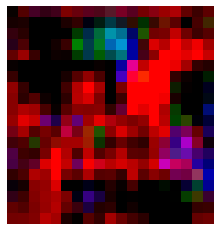

In [91]:
imshow(interpolated_last_panel_face)

In [92]:
copied_last_panel = deepcopy(last_panel)

In [93]:
copied_last_panel[:,
mask_coordinates_n[0]: mask_coordinates_n[1],
mask_coordinates_n[2]: mask_coordinates_n[3]] = interpolated_last_panel_face

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


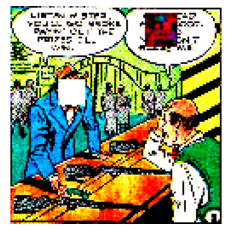

In [94]:
imshow(copied_last_panel)

In [95]:
B, S, C, H, W = x.shape